In [41]:
from typing import Callable
import os 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
# import torchvision.datasets as datasets 
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import matplotlib.pyplot as plt 
import numpy as np 
import warnings
import torch.optim as optim

import scipy
from PIL import Image
import pdb
import pickle
import argparse

warnings.filterwarnings("ignore")

%matplotlib inline
# import tests

In [42]:
def get_data_loader(image_type: str, 
                    transform: Callable,
                    image_dir: str, 
                    batch_size: int = 16, 
                    num_workers: int = 0):
    """
    Returns training and test data loaders for a given image type, either 'summer' or 'winter'.
    These images will be resized to 128x128x3, converted into Tensors, and normalized.
    """
    
    # get training and test directories
    train_path = os.path.join(image_dir, 'trainA', image_type)
    test_path = os.path.join(image_dir, 'trainB', image_type)
    
    # Debugging statements to verify the paths and their contents
    if not os.path.isdir(train_path):
        raise FileNotFoundError(f"Train path does not exist: {train_path}")
    else:
        print(f"Train path exists: {train_path}")
        print(f"Contents of {train_path}: {os.listdir(train_path)}")
        
    if not os.path.isdir(test_path):
        raise FileNotFoundError(f"Test path does not exist: {test_path}")
    else:
        print(f"Test path exists: {test_path}")
        print(f"Contents of {test_path}: {os.listdir(test_path)}")
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(root=os.path.dirname(train_path), transform=transform)
    test_dataset = datasets.ImageFolder(root=os.path.dirname(test_path), transform=transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [43]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define transformations
image_size = 128
transform = Compose([Resize(image_size),  # resize to 128x128
                     ToTensor(),
                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Create train and test dataloaders for images from the two domains X and Y
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer', 
                                                  transform=transform,
                                                  image_dir='archive')

dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter', 
                                                  transform=transform,
                                                  image_dir='archive')


Train path exists: archive/trainA/summer
Contents of archive/trainA/summer: ['2015-10-01 21_38_04.jpg', '2015-07-25 16_30_37.jpg', '2015-08-12 21_53_23.jpg', '2015-08-14 20_07_17.jpg', '2014-07-04 02_24_09.jpg', '2015-09-07 13_27_36.jpg', '2016-08-13 02_21_25.jpg', '2014-07-20 20_12_39.jpg', '2016-05-22 20_01_19.jpg', '2015-09-05 21_17_29.jpg', '2014-09-03 01_26_47.jpg', '2016-06-04 18_22_33.jpg', '2015-06-06 05_45_57.jpg', '2016-05-22 06_23_47.jpg', '2014-07-26 12_59_48.jpg', '2016-06-13 13_57_54.jpg', '2016-06-17 06_08_16.jpg', '2014-06-30 18_59_03.jpg', '2015-08-23 04_20_39.jpg', '2016-09-14 03_30_15.jpg', '2016-09-14 05_35_47.jpg', '2016-09-12 21_39_34.jpg', '2016-09-13 01_08_45.jpg', '2014-06-26 22_14_05.jpg', '2015-06-05 17_02_39.jpg', '2016-08-21 19_02_07.jpg', '2015-07-04 13_01_03.jpg', '2015-06-22 13_14_16.jpg', '2016-06-21 15_46_49.jpg', '2016-08-24 01_11_56.jpg', '2015-07-28 20_02_28.jpg', '2015-09-09 19_09_12.jpg', '2015-07-16 19_47_18.jpg', '2016-07-16 08_13_48.jpg', '2015

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


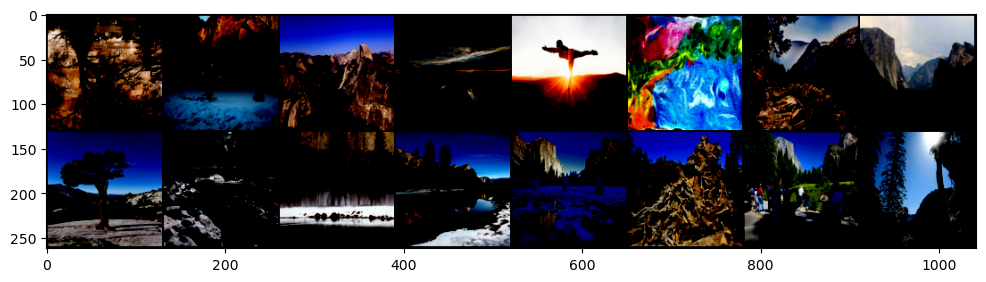

In [44]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader_X)
images,_ = next(dataiter)

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


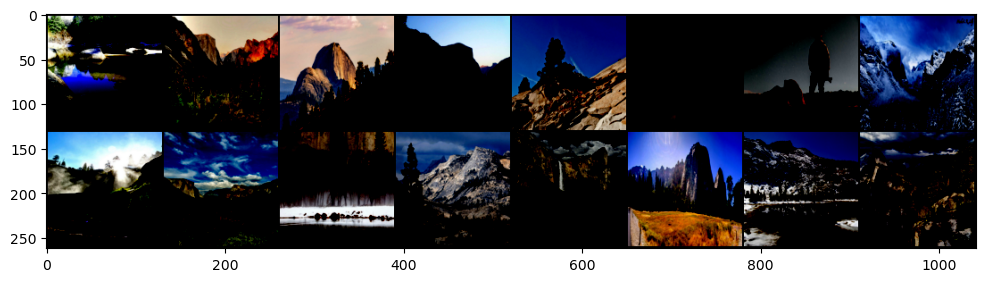

In [45]:
dataiter = iter(dataloader_Y)
images, _ = next(dataiter)

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='cg2\image_deconv.png'>


This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

**The discriminator architecture is not very different from the DCGAN architecture and therefore we will focus on implementing the generator only.**



### Generators :
The generators, G_XtoY and G_YtoX (sometimes called F), are made of an encoder, a conv net that is responsible for turning an image into a smaller feature representation, and a decoder, a transpose_conv net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:


<img src = 'image.png'>


This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called de-conv layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a tanh activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='archive\resuidual.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='cg2\residual_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `ConvBlock` module below to create this block.

In [46]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - use_bn: whether to use batch normalization or not
    - use_activation: whether to use an activation function or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 1,
                 use_bn: bool = True,
                 use_activation: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        
        self.use_bn = use_bn
        if self.use_bn:
            self.bn = nn.BatchNorm2d(out_channels)
            
        self.use_activation = use_activation
        if self.use_activation:
            self.act = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.use_activation:
            x = self.act(x)
        return x

In [47]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = ConvBlock(3, conv_dim, 4, stride=2, use_bn=False) # x, y = 64, depth 64
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4, stride=2, ) # (32, 32, 128)
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4, stride=2) # (16, 16, 256)
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4, stride=2) # (8, 8, 512)
        # Classification layer
        self.conv5 = ConvBlock(conv_dim*8, 1, 8, stride=1, padding=0, use_bn=False, use_activation=False)
        

    def forward(self, x):
        # relu applied to all conv layers but last
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        # last, classification layer
        out = self.conv5(out)
        return out

In [48]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv_block1 = ConvBlock(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3)
        self.conv_block2 = ConvBlock(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, use_activation=False)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = self.conv_block1(x)
        out_2 = x + self.conv_block2(out_1)
        return out_2

In [49]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 2,
                 padding: int = 1,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [50]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim: int = 64, n_res_blocks: int = 6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = ConvBlock(3, conv_dim, 4, stride=2)
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4, stride=2)
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4, stride=2)

        # 2. Define the resnet part of the generator
        # Residual blocks
        self.res_layers = nn.ModuleList()
        for layer in range(n_res_blocks):
            self.res_layers.append(ResidualBlock(conv_dim*4))

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = DeconvBlock(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = DeconvBlock(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False)
        self.final_act = nn.Tanh()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        for layer in self.res_layers:
            out = layer(out)
        
        out = self.deconv1(out)
        out = self.deconv2(out)
        # tanh applied to last layer
        out = self.deconv3(out)
        out = self.final_act(out)
        return out

In [51]:
generator = CycleGenerator()

In [52]:
def check_cycle_generator(generator: nn.Module):
    image = torch.randn(1, 3, 128, 128)
    output = generator(image)
    print(output.shape)


In [53]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [54]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [55]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (res_layers): ModuleList(
    (0-5): 6 x ResidualBlock(
      (conv_block1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(

In [56]:
check_cycle_generator(generator)

torch.Size([1, 3, 128, 128])


### real_mse_loss:
 that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.


### fake_mse_loss: 
that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.


### cycle_consistency_loss:
 that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a lambda_weight parameter that will weight the mean absolute error in a batch.

In [57]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


In [58]:
# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [63]:
def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan', suffix=""):
    """Saves samples from both generators X->Y and Y->X."""
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y{}.png'.format(iteration, suffix))
    Image.fromarray(merged.astype(np.uint8)).save(path)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X{}.png'.format(iteration, suffix))
    Image.fromarray(merged.astype(np.uint8)).save(path)
    print('Saved {}'.format(path))

In [64]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training parameters
n_epochs = 4000  # keep this small when testing if a model first works
print_every = 10
sample_every = 100
checkpoint_every = 1000

# Keep track of losses over time
losses = []

# Get iterators for test data loaders
test_iter_X = iter(test_dataloader_X)
test_iter_Y = iter(test_dataloader_Y)

# Get some fixed data from domains X and Y for sampling
fixed_X = next(test_iter_X)[0].to(device)
fixed_Y = next(test_iter_Y)[0].to(device)

# Training loop
for epoch in range(1, n_epochs + 1):
    # Reset iterators for each epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(dataloader_X), len(dataloader_Y))

    for i in range(batches_per_epoch):
        images_X, _ = next(iter_X)
        images_Y, _ = next(iter_Y)

        # Move images to device
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        # Ensure models are on the same device
        G_YtoX = G_YtoX.to(device)
        G_XtoY = G_XtoY.to(device)
        D_X = D_X.to(device)
        D_Y = D_Y.to(device)

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # Train D_X
        d_x_optimizer.zero_grad()
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X.detach())
        D_X_fake_loss = fake_mse_loss(out_x)
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        # Train D_Y
        d_y_optimizer.zero_grad()
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y.detach())
        D_Y_fake_loss = fake_mse_loss(out_y)
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        # Train Generators G_YtoX and G_XtoY
        g_optimizer.zero_grad()

        # Generator loss for G_YtoX
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # Cycle consistency loss for Y -> X -> Y
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_Y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

        # Generator loss for G_XtoY
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # Cycle consistency loss for X -> Y -> X
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_X_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # Total generator loss
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_Y_loss + reconstructed_X_loss
        g_total_loss.backward()
        g_optimizer.step()

        # Print log info
        if epoch % print_every == 0 and i == batches_per_epoch - 1:
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

        # Save generated samples
        if epoch % sample_every == 0 and i == batches_per_epoch - 1:
            G_YtoX.eval()
            G_XtoY.eval()
            with torch.no_grad():
                # Save fixed samples
                save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
                # Save non-fixed samples for variability
                save_samples(epoch, images_Y, images_X, G_YtoX, G_XtoY, batch_size=16, suffix="_nonfixed")
            G_YtoX.train()
            G_XtoY.train()

        # Save model checkpoints
        if epoch % checkpoint_every == 0 and i == batches_per_epoch - 1:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)


Epoch [   10/ 4000] | d_X_loss: 0.0940 | d_Y_loss: 0.2526 | g_total_loss: 16.1429
Epoch [   20/ 4000] | d_X_loss: 0.0145 | d_Y_loss: 0.1898 | g_total_loss: 15.9172
Epoch [   30/ 4000] | d_X_loss: 0.0299 | d_Y_loss: 0.0627 | g_total_loss: 17.4568
Epoch [   40/ 4000] | d_X_loss: 0.0031 | d_Y_loss: 0.2499 | g_total_loss: 18.5906
Epoch [   50/ 4000] | d_X_loss: 0.0027 | d_Y_loss: 0.1601 | g_total_loss: 17.5763
Epoch [   60/ 4000] | d_X_loss: 0.0039 | d_Y_loss: 0.0487 | g_total_loss: 18.6310
Epoch [   70/ 4000] | d_X_loss: 0.0034 | d_Y_loss: 0.5520 | g_total_loss: 17.8322
Epoch [   80/ 4000] | d_X_loss: 0.0147 | d_Y_loss: 0.0210 | g_total_loss: 17.6785
Epoch [   90/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.1067 | g_total_loss: 16.4764
Epoch [  100/ 4000] | d_X_loss: 0.0047 | d_Y_loss: 0.0131 | g_total_loss: 17.0373
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Saved samples_cyclegan/sample-000100-X-Y_nonfixed.png
Saved samples_cyclegan/sample-000100

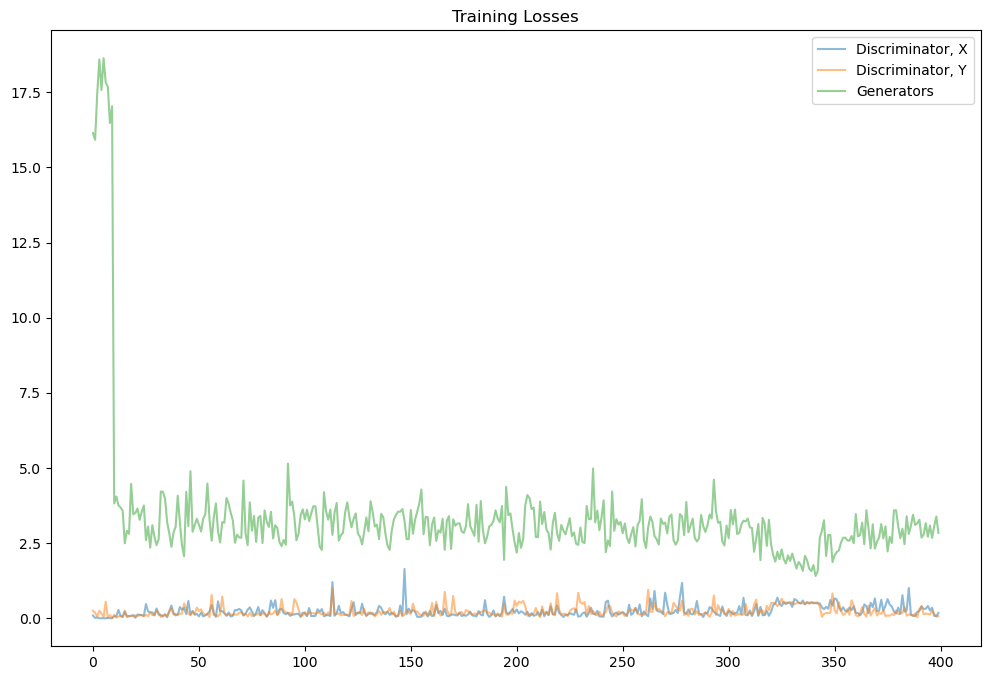

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [66]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


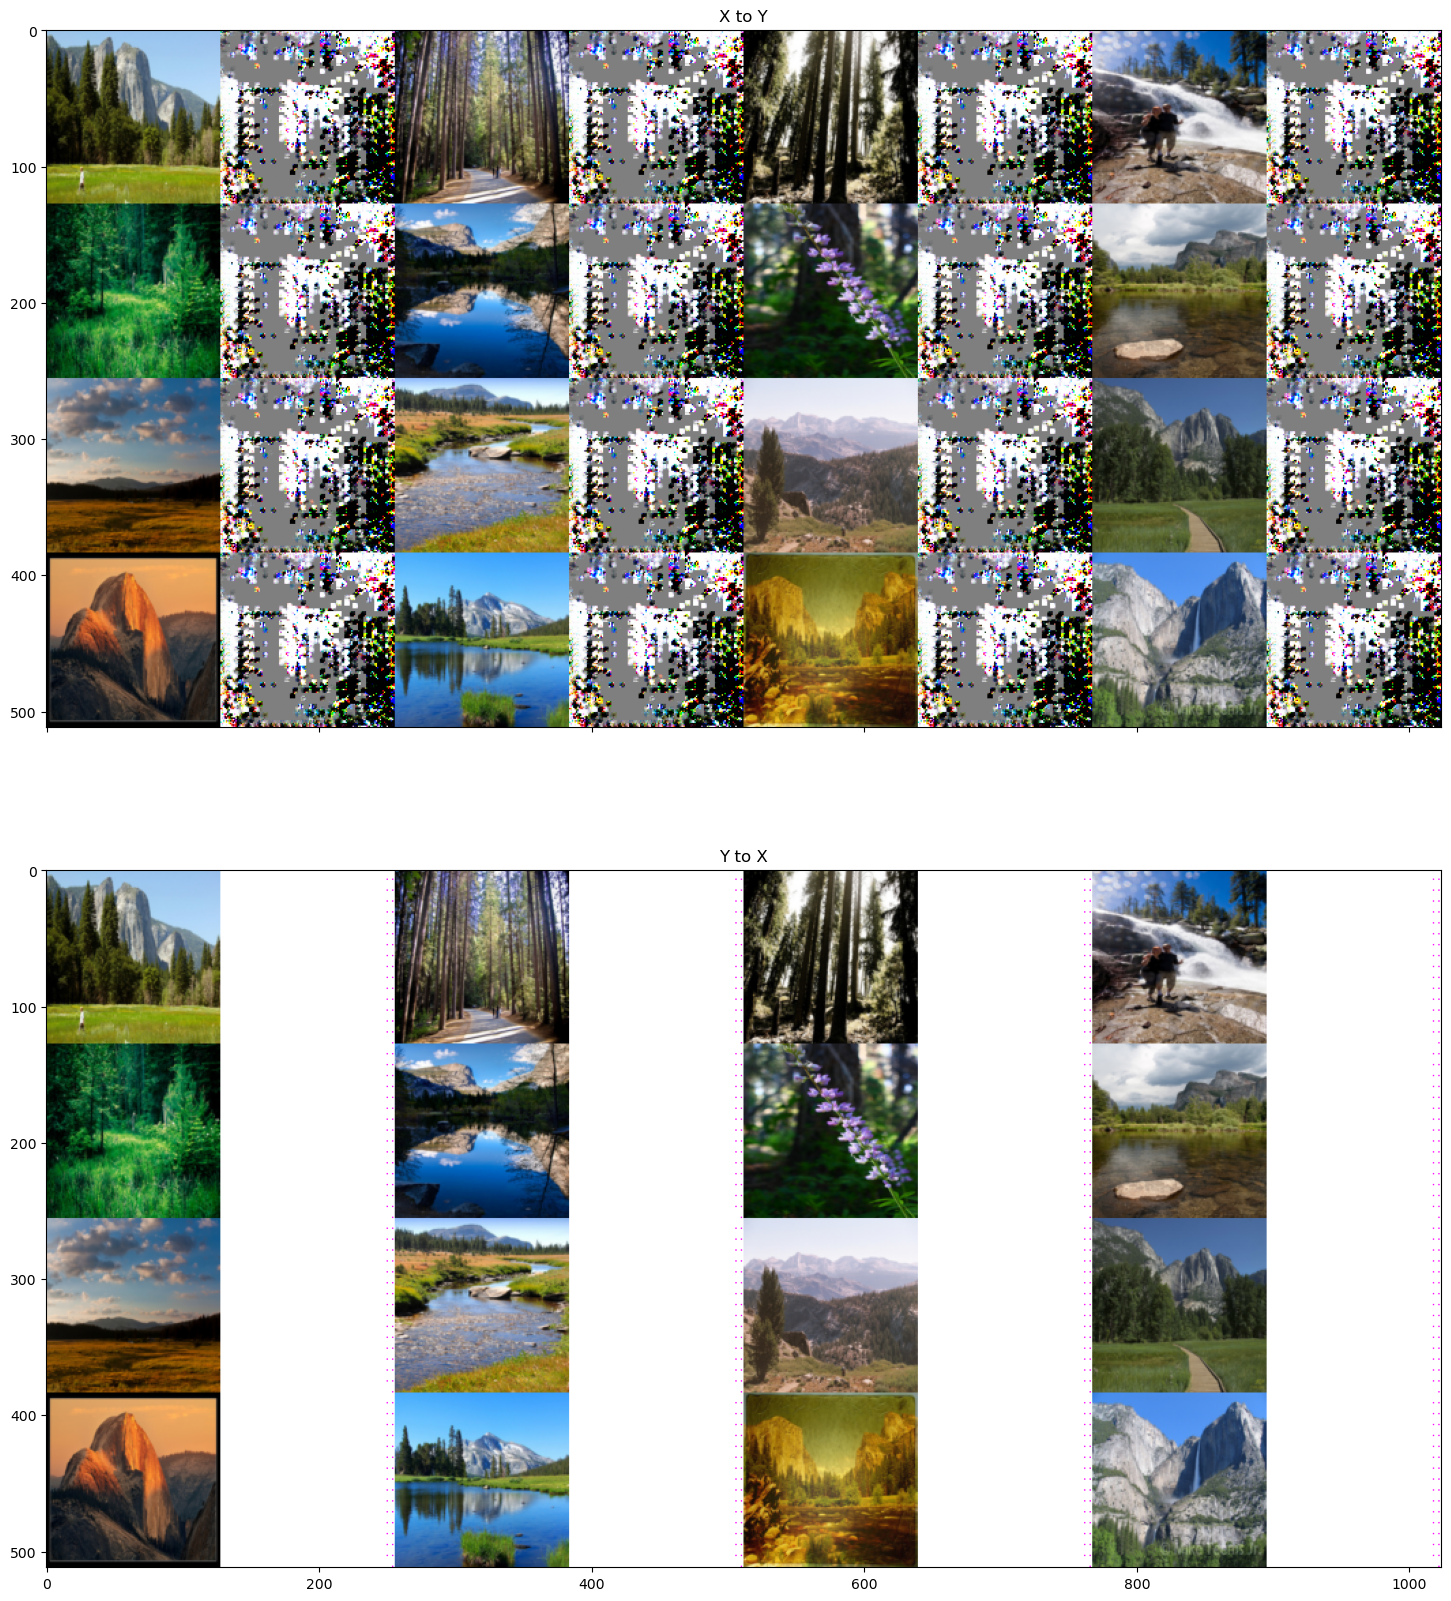

In [67]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

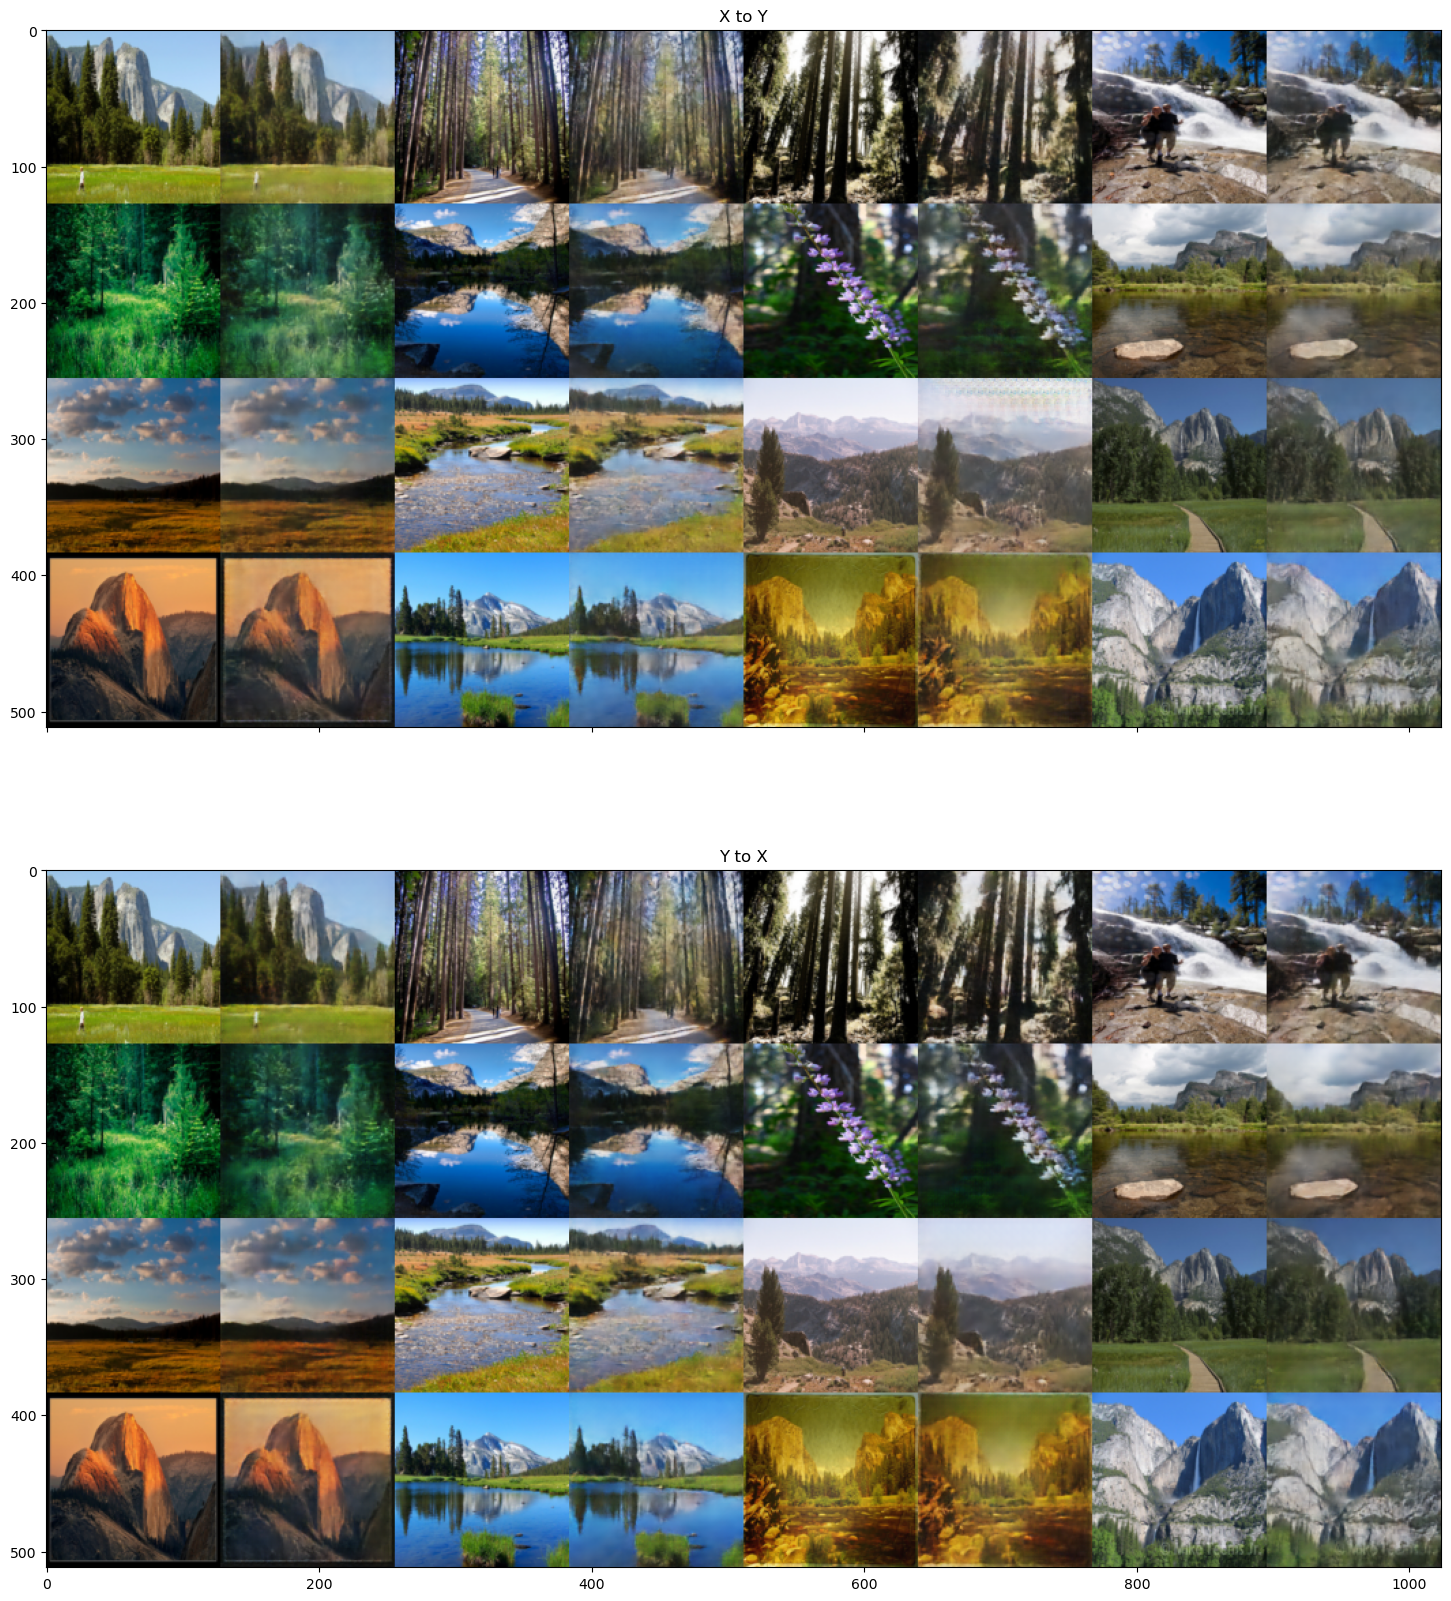

In [68]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')